# ISB-CGC Community Notebooks
Check out more notebooks at our [Community Notebooks Repository](https://github.com/isb-cgc/Community-Notebooks)!

- **Title:**   How to cluster data using a BigQuery user defined function
- **Author:**  Boris Aguilar
- **Created:** 2020-11-19
- **Purpose:** Demostrate how to cluster gene expression data using the k-mean method implemented as a BigQuery user defined function.
- **URL:**     https://github.com/isb-cgc/Community-Notebooks/blob/master/Notebooks/How_to_cluster_data_using_a_BigQuery_function.ipynb
- **Note1:**   This notebook was adapted from the Query of the month of February 2017, developed by David Gibbs: ['Using BigQuery, define K-means clustering as a user defined (javascript) function'](https://isb-cancer-genomics-cloud.readthedocs.io/en/latest/sections/QueryOfTheMonthClub.html#february2017).
- **Note2:** Works in Google Colaboratory notebooks

This notebook demostrates how to use the ```kmeans_current``` function available in the ```isb-cgc-bq.functions``` dataset for clustering numerical data. This notebook uses Breast cancer gene expression data of two user defined genes in the BigQuery table ```isb-cgc.tcga_201607_beta.mRNA_UNC_RSEM```, but this example should also work on other numerical BigQuery table.

## Software and libraries

In [11]:
#pip install --upgrade google-cloud-bigquery

In [2]:
from google.cloud import bigquery
from google.colab import auth
import google.auth
import pandas as pd
import seaborn as sns

## Authentication
Before using BigQuery we need to authorize access to BigQuery and the Google Cloud. For more information see ['Quick Start Guide to ISB-CGC'](https://isb-cancer-genomics-cloud.readthedocs.io/en/latest/sections/HowToGetStartedonISB-CGC.html) and alternative authentication methods can be found [here](https://googleapis.dev/python/google-api-core/latest/auth.html).

In [3]:
auth.authenticate_user()
my_project_id = "my_google_project" # write your project id here
bqclient = bigquery.Client( my_project_id )

## Parameters
In this experiment we use the gene expression of two genes (```gene1``` and ```gene2```) in Breast cancer. The clustering of the data is performed by using the ```k-means``` method implemented as BigQuery function, ```isb-cgc-bq.function.kmeans_current```. In addition to the gene expression data, the function requires two additional parameteres, the number of iterations and the number of cluster.

In [4]:
gene1 = 'ESR1' 
gene2 = 'EGFR'
study = 'BRCA'
niterations = 200
nclusters = 2

## Queries
The following code generates a sub query to access the gene expression data of a gene. This subquery requires the table name(```{0}```), the cancer type (```{1}```), and the gene symbol (```{2}```). 

In [5]:
gequery = """{0} AS (
  SELECT
    AliquotBarcode AS barcode,
    AVG(LOG(normalized_count+1, 2)) AS count
  FROM
    `isb-cgc.tcga_201607_beta.mRNA_UNC_RSEM`
  WHERE
    Study = '{1}'
    AND SampleTypeLetterCode = 'TP'
    AND HGNC_gene_symbol = '{2}'
    AND normalized_count >= 0
  GROUP BY
    AliquotBarcode, gene_id )
 """

The folowing query first combines the gene expression of the two genes using the ```JOIN``` command, and then calls the ```isb-cgc-bq.functions.kmeans_current``` on the gene expression (```m1.count``` and ```m2.count```) data. 

In [6]:
clustering = """results AS (
SELECT
    ARRAY_AGG(m1.count ORDER BY m1.barcode) AS esr1_a,
    ARRAY_AGG(m2.count ORDER BY m1.barcode) AS egfr_a,
    `isb-cgc-bq.functions.kmeans_current`( ARRAY_AGG( STRUCT([m1.count,m2.count]) ORDER BY m1.barcode ), {0},{1} ) AS cluster 
  FROM
    gene1 AS m1
  JOIN
    gene2 AS m2
  ON
    m1.barcode = m2.barcode 
)""".format( str(niterations), str(nclusters)  )

Finally we generate the query that will perform the clustering on genexpression data.

In [7]:
query = "WITH " + \
        gequery.format('gene1',study,gene1) + "," + \
        gequery.format('gene2',study,gene2) + "," + \
        clustering +  """
SELECT  cluster, 
        esr1_a[OFFSET(myoffset)] AS ESR1,
        egfr_a[OFFSET(myoffset)] AS EGFR
FROM results, 
     results.cluster as cluster WITH OFFSET AS myoffset
"""
# print(query)

## Run BigQuery
The following commands run the generated query in google BigQuery. The results are saved in a pandas dataframe where the first column represents the cluster id and the second and third columns represent the gene expression of gene1 and gene2 respectively.

In [8]:
try:
    query_job = bqclient.query ( query )
except:
    print ( "  FATAL ERROR: query execution failed " )

In [9]:
df = query_job.to_dataframe()
df

,cluster,ESR1,EGFR
0,0,11.756123,5.756957
1,1,6.119263,6.227918
2,0,12.869463,5.533903
3,0,11.279792,7.994499
4,0,12.430269,7.368516
...,...,...,...
1090,0,12.154738,5.616340
1091,0,11.416004,8.697556
1092,0,11.288153,8.435642
1093,0,11.689289,6.584566


## Plot the results
Finally we can generate a scatter plot coloring the gene expression data by the cluster id.

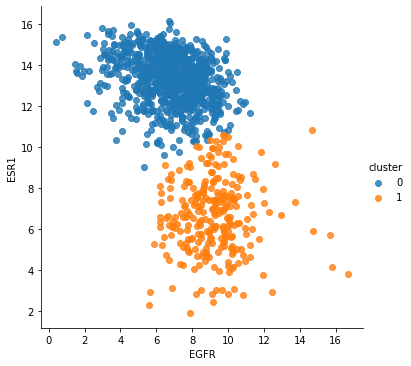

In [10]:
sns.lmplot( x="EGFR", y="ESR1", data=df, fit_reg=False, hue='cluster')